In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings

In [3]:
# Part 1 - Getting the data and defining parameters
train_datagen = ImageDataGenerator(rescale = 1./255)
training_set = train_datagen.flow_from_directory(r'/content/drive/MyDrive/ABIDE-I dataset/A_Prepared_Data/train',
                                                 target_size = (64, 64),
                                                 class_mode = 'binary',
                                                 color_mode = 'grayscale'
                                                 )

validation_set = train_datagen.flow_from_directory(r'/content/drive/MyDrive/ABIDE-I dataset/A_Prepared_Data/validate',
                                                 target_size = (64, 64),
                                                 class_mode = 'binary',
                                                 color_mode = 'grayscale'
                                                 )
test_datagen = ImageDataGenerator(rescale = 1./255)
test_set = test_datagen.flow_from_directory(r'/content/drive/MyDrive/ABIDE-I dataset/A_Prepared_Data/test',
                                            target_size = (64, 64),
                                            class_mode = 'binary',
                                            color_mode = 'grayscale')

Found 7186 images belonging to 2 classes.
Found 1450 images belonging to 2 classes.
Found 2450 images belonging to 2 classes.


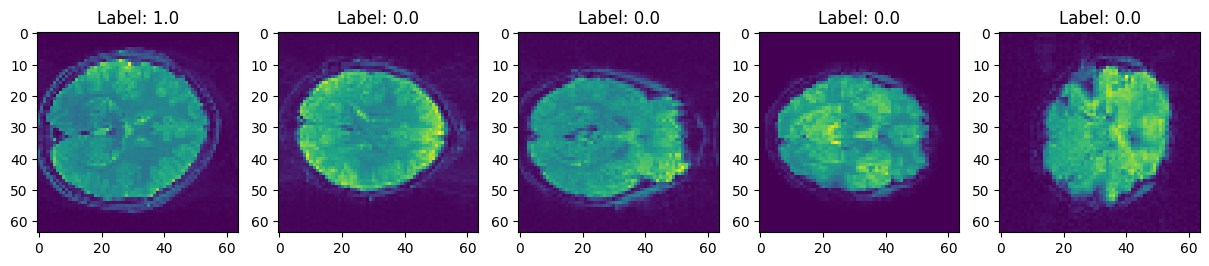

'\n0.0 -0.48501962 0.59239614\n0.0 -0.48501962 0.59239614\n1.0 -0.48501962 0.59239614\n1.0 -0.48501962 0.59239614\n1.0 -0.48501962 0.59239614\n'

In [4]:
num_images_to_plot = 5
fig, axes = plt.subplots(1, num_images_to_plot, figsize=(15, 3))

for i in range(num_images_to_plot):
    # Get a batch of augmented images
    batch = training_set.next()

    # Extract the first image and label from the batch
    image = batch[0][0]
    label = batch[1][0]



    # Display the image and label
    axes[i].imshow(image)
    axes[i].set_title(f'Label: {label}')

plt.show()
# print(label, image.min(), image.max())
"""
0.0 -0.48501962 0.59239614
0.0 -0.48501962 0.59239614
1.0 -0.48501962 0.59239614
1.0 -0.48501962 0.59239614
1.0 -0.48501962 0.59239614
"""

In [ ]:
image_names = training_set.filenames
labels = training_set.labels

for i in range(len(image_names)):
    print(f"Image Name: {image_names[i]}, Label: {labels[i]}")

# Image Name: ASD/slice0050815_025.png, Label: 0
# Image Name: TC/slice0050040_015.png, Label: 1

In [17]:
# Part 2 - Creating the CNN model

# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Conv2D, Dropout, BatchNormalization
from keras.layers import MaxPooling2D, Activation
from keras.layers import Flatten
from keras.layers import Dense

# Initialising the CNN
classifier = Sequential()

# input and first convolution
classifier.add(Conv2D(32, (3, 3), input_shape = (64, 64, 1)))
classifier.add(BatchNormalization())
classifier.add(Activation('relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Adding a second convolutional layer
classifier.add(Conv2D(64, (3, 3)))
classifier.add(BatchNormalization())
classifier.add(Activation('relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))


# Adding a third convolutional layer
classifier.add(Conv2D(128, (3, 3)))
classifier.add(BatchNormalization())
classifier.add(Activation('relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))


# Adding a fourth convolutional layer
classifier.add(Conv2D(128, (3, 3)))
classifier.add(BatchNormalization())
classifier.add(Activation('relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))
# classifier.add(Dropout(0.5))

# Step 3 - Flattening
classifier.add(Flatten())

# Step 4 - Full connection
classifier.add(Dense(units = 128))
classifier.add(BatchNormalization())
classifier.add(Activation('relu'))
# classifier.add(Dropout(0.5))

classifier.add(Dense(units = 64))
classifier.add(BatchNormalization())
classifier.add(Activation('relu'))
# classifier.add(Dropout(0.5))

classifier.add(Dense(units = 1, activation = 'sigmoid'))

In [18]:
base_learning_rate = 0.001
classifier.compile(loss='binary_crossentropy',
              optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              metrics= ['accuracy'])

In [19]:
classifier.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 62, 62, 32)        320       
                                                                 
 batch_normalization_18 (Ba  (None, 62, 62, 32)        128       
 tchNormalization)                                               
                                                                 
 activation_18 (Activation)  (None, 62, 62, 32)        0         
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 31, 31, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 29, 29, 64)        18496     
                                                                 
 batch_normalization_19 (Ba  (None, 29, 29, 64)       

In [20]:
# tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("/content/drive/MyDrive/ABIDE-I dataset/basicmodelone",monitor="val_accuracy",save_best_only=True,verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.2, patience = 2, min_delta = 0.001,verbose=1)

In [21]:
history = classifier.fit(training_set,
                                   steps_per_epoch=training_set.n // 32,
                                   epochs=20,  # Specify the number of epochs
                                   validation_data=validation_set,
                                   validation_steps = validation_set.n // 32,
                                   callbacks=[checkpoint, reduce_lr]
                                   )


Epoch 1/20
224/224 [==============================] - ETA: 0s - loss: 0.6789 - accuracy: 0.5791
Epoch 1: val_accuracy improved from -inf to 0.63611, saving model to /content/drive/MyDrive/ABIDE-I dataset/basicmodelone
224/224 [==============================] - 1399s 6s/step - loss: 0.6789 - accuracy: 0.5791 - val_loss: 0.6589 - val_accuracy: 0.6361 - lr: 0.0010
Epoch 2/20
224/224 [==============================] - ETA: 0s - loss: 0.6172 - accuracy: 0.6473
Epoch 2: val_accuracy did not improve from 0.63611
224/224 [==============================] - 18s 83ms/step - loss: 0.6172 - accuracy: 0.6473 - val_loss: 0.7017 - val_accuracy: 0.5097 - lr: 0.0010
Epoch 3/20
224/224 [==============================] - ETA: 0s - loss: 0.5492 - accuracy: 0.7122
Epoch 3: val_accuracy did not improve from 0.63611

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
224/224 [==============================] - 21s 93ms/step - loss: 0.5492 - accuracy: 0.7122 - val_loss: 0.6794 - val_ac

___

In [22]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns


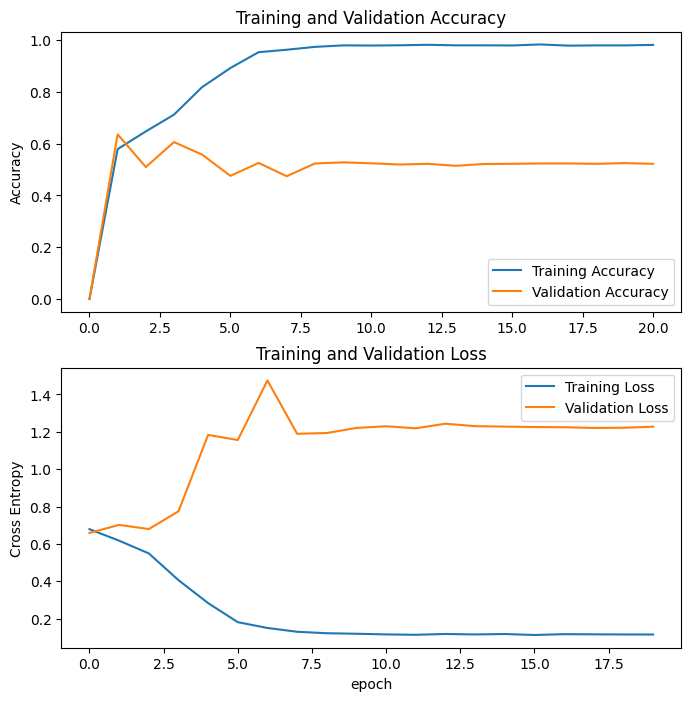

In [25]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
# plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
# plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [26]:
# Evaluate the performance of the model
evaluate = classifier.evaluate(test_set, steps = test_set.n // 32, verbose =1)

print('Accuracy Test : {}'.format(evaluate[1]))

76/76 [==============================] - 628s 8s/step - loss: 1.5717 - accuracy: 0.4404
Accuracy Test : 0.4403782784938812


77/77 [==============================] - 5s 64ms/step
Test Accuracy: 50.41%


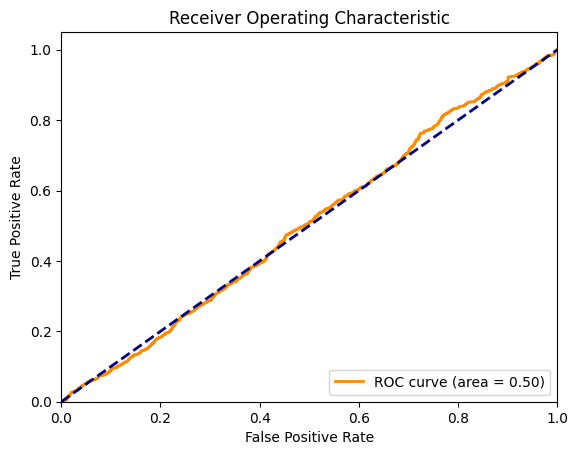

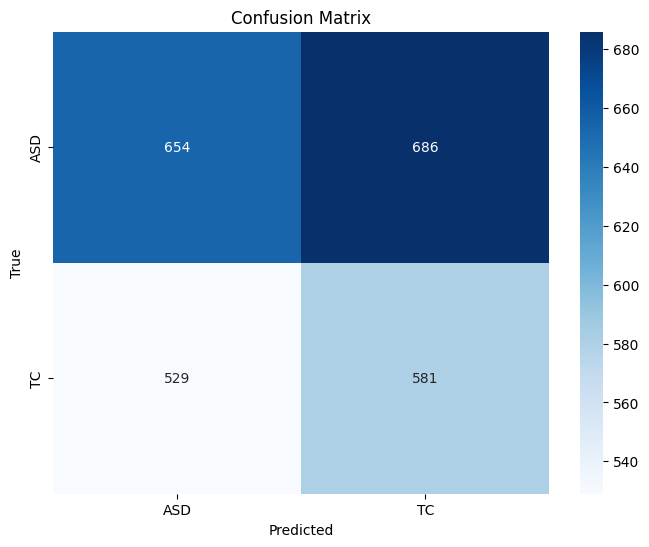

Confusion Matrix:
[[654 686]
 [529 581]]


In [27]:
# Get the list of class names from the data generator
class_names = list(training_set.class_indices.keys())

# Make predictions on the test data
predictions = classifier.predict(test_set)

# 'predictions' will contain the predicted probabilities for each image
# For binary classification, you can threshold the probabilities to get class predictions (0 or 1)
predicted_classes = (predictions > 0.5).astype(int)

# Get the true class labels for the test data
true_classes = test_set.classes

# Calculate test accuracy
test_accuracy = accuracy_score(true_classes, predicted_classes)

# Print and return the test accuracy
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Calculate the ROC curve
fpr, tpr, _ = roc_curve(true_classes, predictions)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

# Calculate the confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print and return the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)



In [ ]:
file_names = test_set.filenames

# Iterate through the predictions and file names
for i in range(len(predicted_classes)):
    file_name = os.path.basename(file_names[i])
    class_name = class_names[predicted_classes[i][0]]

    print(f"File: {file_name}, Predicted Class: {class_name}")

